In [190]:
!pip install fancyimpute

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
# ---------------- Imports ----------------
# Data manipulation and analysis
import pandas as pd
import numpy as np
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Machine learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine learning - Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from fancyimpute import KNN

# Machine learning - Metrics
from sklearn.metrics import mean_squared_error

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

In [193]:
# Upload csv
# df = pd.read_csv('/Users/ronimuradov/Desktop/Docs/סמסטר ה׳/למידת מכונה/פרויקט/sberbank-russian-housing-market/train.csv')
df = pd.read_csv('/content/drive/MyDrive/פרויקט למידת מכונה/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/פרויקט למידת מכונה/Manipulated_Test.csv')

In [194]:
print(test_df.shape)
print(df.shape)

(7662, 563)
(30471, 292)


In [195]:
# Identifying missing values in each feature
missing_values = df.isnull().sum()

# Calculating the percentage of missing values for each feature
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Combining both the count and percentage of missing values into a DataFrame
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Sorting the features by percentage of missing values in descending order
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

missing_df

,Missing Values,Percentage
hospital_beds_raion,14441,47.392603
build_year,13605,44.649011
state,13559,44.498047
cafe_sum_500_max_price_avg,13281,43.585704
cafe_sum_500_min_price_avg,13281,43.585704
cafe_avg_price_500,13281,43.585704
max_floor,9572,31.413475
material,9572,31.413475
num_room,9572,31.413475
kitch_sq,9572,31.413475


In [196]:
# Split cols to categorical and numerical
# Modified to include both string and numeric columns
columns_of_interest = df.select_dtypes(include=['object', 'int64', 'float64']).columns

categorial_features = []

for col in columns_of_interest:
    if df[col].nunique() < 10:
        categorial_features.append(col)

print("categorial_features", categorial_features)

all_numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [feature for feature in all_numeric_features if feature not in categorial_features]

# Exclude categorical features that are numerically encoded from the numeric_features list (not to be in categorial numeric)
numeric_features = [feature for feature in all_numeric_features if feature not in categorial_features]

print("Final numeric features, excluding categorical ones:", numeric_features)

categorial_features ['material', 'state', 'product_type', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'culture_objects_top_25', 'culture_objects_top_25_raion', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'build_count_foam', 'build_count_mix', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ID_railroad_terminal', 'ecology', 'trc_count_500', 'cafe_count_500_price_high', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_high', 'mosque_count_1000', 'market_count_1000', 'mosque_count_1500', 'market_count_1500', 'mosque_count_2000', 'market_count_2000', 'mosque_count_3000', 'mosque_count_5000']
Final numeric features, excluding categorical ones: ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'area_m', 'raion_popul', 'green_zone_part', 

In [197]:
df_numeric = df[numeric_features]

# Outliers detection
features = df_numeric.columns  # Work directly with numeric features

Q1 = df_numeric.quantile(0.02)
Q3 = df_numeric.quantile(0.98)
IQR = Q3 - Q1

# Determining the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# delete outliers from the data
df = df[~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)

#delete all negative values in numeric features
df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,29889.000000,29889.000000,23651.000000,29724.000000,20424.000000,20424.000000,16530.000000,20424.000000,20424.000000,16559.000000,...,29889.000000,29889.000000,29889.000000,29889.000000,29889.000000,29889.000000,29889.000000,29889.000000,29889.000000,2.988900e+04
mean,15177.491652,53.562682,33.670754,7.719890,12.634743,1.821289,1882.289353,1.900313,5.847630,2.109608,...,30.960521,10.324501,1.683997,14.670949,29.666399,0.440865,8.326274,52.586704,5.999632,7.042663e+06
std,8788.019919,20.404758,18.278701,5.302509,6.589900,1.477934,441.863800,0.825493,3.964983,0.843327,...,71.226283,27.446317,5.238728,28.362196,46.036243,0.606049,19.944937,45.545004,4.874156,4.228980e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7557.000000,38.000000,20.000000,3.000000,9.000000,1.000000,1967.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.767480e+06
50%,15145.000000,49.000000,30.000000,7.000000,12.000000,1.000000,1979.000000,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.289886e+06
75%,22786.000000,63.000000,43.000000,11.000000,17.000000,2.000000,2005.000000,2.000000,9.000000,3.000000,...,21.000000,4.000000,0.000000,12.000000,28.000000,1.000000,6.000000,75.000000,10.000000,8.279537e+06
max,30472.000000,226.000000,191.000000,44.000000,48.000000,6.000000,4965.000000,8.000000,35.000000,4.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,215.000000,21.000000,4.619127e+07


In [198]:
# Select columns that are integers
int_features = df.select_dtypes(include=['int64']).columns.tolist()

# Select columns that are floats
float_features = df.select_dtypes(include=['float64']).columns.tolist()

# Print the lists
print("Integer features:", int_features)
print("Float features:", float_features)

Integer features: ['id', 'full_sq', 'raion_popul', 'children_preschool', 'preschool_education_centers_raion', 'children_school', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'ID_metro', 'ID_railroad_station_avto', 'ID_big_road1', 'ID_big_road2', 'ID_railroad_terminal', 'ID_bus_terminal', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_count_500_na_price', 'cafe_count_500_price_50

In [199]:
# Print initial data types for verification
print("Initial data types (selected):")
print(df[float_features].dtypes)

for col in float_features:
    # Check if all non-NaN entries in the column are integers
    if df[col].dropna().apply(lambda x: x % 1 == 0).all():
        print(f"Converting {col} to integers.")

        # Convert to Int64 dtype while preserving NaNs
        df[col] = df[col].astype('Int64')

# Verify changes by checking data types again
print("\nUpdated data types (selected):")
conversion_results = df[float_features].dtypes
print(conversion_results)

Initial data types (selected):
life_sq                        float64
floor                          float64
max_floor                      float64
material                       float64
build_year                     float64
                                ...   
green_part_5000                float64
prom_part_5000                 float64
cafe_sum_5000_min_price_avg    float64
cafe_sum_5000_max_price_avg    float64
cafe_avg_price_5000            float64
Length: 119, dtype: object
Converting life_sq to integers.
Converting floor to integers.
Converting max_floor to integers.
Converting material to integers.
Converting build_year to integers.
Converting num_room to integers.
Converting kitch_sq to integers.
Converting state to integers.
Converting preschool_quota to integers.
Converting school_quota to integers.
Converting hospital_beds_raion to integers.
Converting raion_build_count_with_material_info to integers.
Converting build_count_block to integers.
Converting build_count_wood t

In [200]:
# Select columns that are integers
int_features = df.select_dtypes(include=['int64']).columns.tolist()

# Select columns that are floats
float_features = df.select_dtypes(include=['float64']).columns.tolist()

# Print the lists
print("Integer features:", int_features)
print("Float features:", float_features)

Integer features: ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'raion_popul', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'b

In [201]:
# # Create an imputer object with the number of neighbors
# imputer = KNN(k=10)

# # Get the unique values of the "sub_area" feature
# sub_areas = df["sub_area"].unique()

# # Create an empty dataframe to store the imputed data
# df_imputed = pd.DataFrame()

# # Iterate over sub_areas
# for sub_area in sub_areas:
#     # Subset the data based on the current sub_area
#     subset_data = df[df["sub_area"] == sub_area].copy()

#     # Drop columns that are not needed for imputation
#     subset_chunk = subset_data.drop(['price_doc','timestamp', 'sub_area'] + categorial_features, axis=1)

#     #subset_chunk = pd.concat([subset_chunk, df[['material', 'build_count_mix', 'state', 'build_count_foam']]])
#     # Perform KNN imputation on the subset
#     imputed_subset = imputer.fit_transform(subset_chunk)

#     # Assign the imputed values back to the subset
#     subset_data.loc[:, subset_chunk.columns] = imputed_subset

#     # Concatenate the imputed subset with the previous imputed data
#     df_imputed = pd.concat([df_imputed, subset_data], ignore_index=True)

# # Assign the imputed values back to the original dataframe
# df = df_imputed

In [202]:
# Impute missing values for integers with median
df[int_features] = df[int_features].fillna(df[int_features].median())

# Impute missing values for floats with mean
df[float_features] = df[float_features].fillna(df[float_features].mean())

Model Enhancement - Feature Engineering

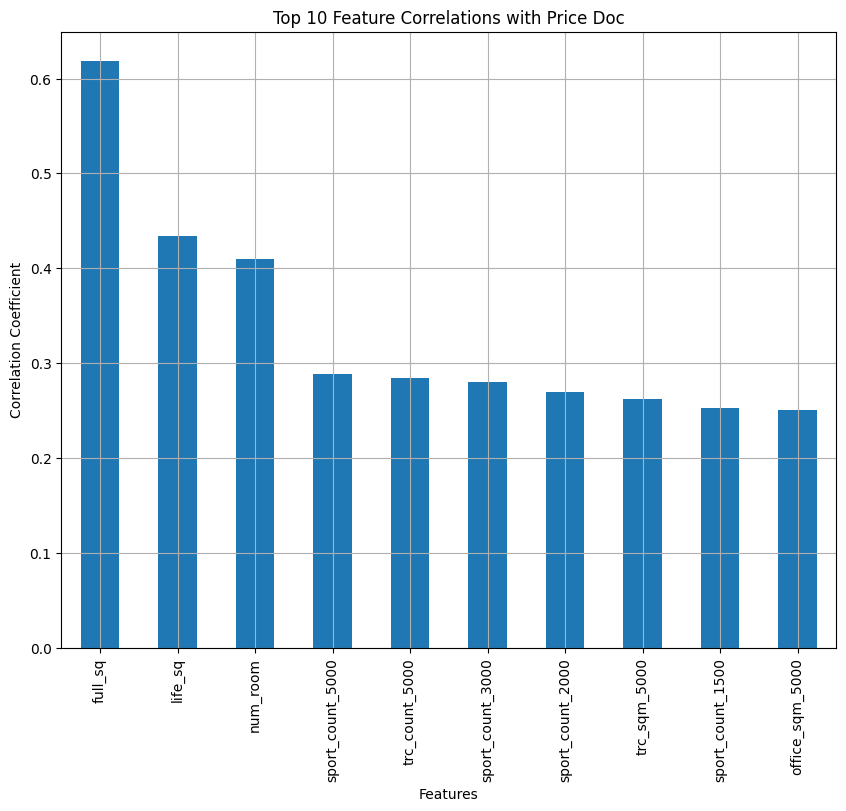

In [203]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Isolate the correlation coefficients for 'price_doc' and sort them
price_doc_corr = corr_matrix['price_doc'].sort_values(ascending=False)

# Remove 'price_doc' correlation with itself for clarity in the plot
price_doc_corr = price_doc_corr[price_doc_corr.index != 'price_doc']

# Plotting the correlation with 'price_doc', showing only the top 10 features
plt.figure(figsize=(10, 8))
price_doc_corr.head(10).plot(kind='bar')  # Correctly applying head(10) to select top 10 features
plt.title('Top 10 Feature Correlations with Price Doc')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

In [204]:
# Polynomial Features
df['full_sq ** 2'] = df['full_sq'] ** 2
df['life_sq ** 2'] = df['life_sq'] ** 2
df['num_room ** 2'] = df['num_room'] ** 2

<ipython-input-204-c866c34ee94f>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['full_sq ** 2'] = df['full_sq'] ** 2
<ipython-input-204-c866c34ee94f>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['life_sq ** 2'] = df['life_sq'] ** 2
<ipython-input-204-c866c34ee94f>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

In [205]:
# Interaction Terms
# Transport-related Interactions
df['railroad_station_avto_km_x_railroad_station_avto_min'] = df['railroad_station_avto_km'] * df['railroad_station_avto_min']

# Distance-related Interactions
df['mkad_km_x_ttk_km'] = df['mkad_km'] * df['ttk_km']
df['kremlin_km_x_big_road1_km'] = df['kremlin_km'] * df['big_road1_km']

# Healthcare-related Interactions
df['public_healthcare_km_x_hospice_morgue_km'] = df['public_healthcare_km'] * df['hospice_morgue_km']
df['university_km_x_public_healthcare_km'] = df['university_km'] * df['public_healthcare_km']

# Cultural-related Interactions
df['theater_km_x_museum_km'] = df['theater_km'] * df['museum_km']
df['church_synagogue_km_x_mosque_km'] = df['church_synagogue_km'] * df['mosque_km']

# Commercial-related Interactions
df['shopping_centers_km_x_office_km'] = df['shopping_centers_km'] * df['office_km']
df['market_shop_km_x_office_count_500'] = df['market_shop_km'] * df['office_count_500']

# Recreational-related Interactions
df['fitness_km_x_swim_pool_km'] = df['fitness_km'] * df['swim_pool_km']
df['ice_rink_km_x_stadium_km'] = df['ice_rink_km'] * df['stadium_km']

# Feature Engineering
df['living_to_total_area_ratio'] = df['life_sq'] / df['full_sq']
df['area_per_room'] = df['full_sq'] / df['num_room']

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['transaction_year'] = df['timestamp'].dt.year
df['rooms_per_sqm'] = df['num_room'] / df['full_sq']
df['age_of_building'] = df['transaction_year'] - df['build_year']

<ipython-input-205-fe01ade359e2>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['railroad_station_avto_km_x_railroad_station_avto_min'] = df['railroad_station_avto_km'] * df['railroad_station_avto_min']
<ipython-input-205-fe01ade359e2>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['mkad_km_x_ttk_km'] = df['mkad_km'] * df['ttk_km']
<ipython-input-205-fe01ade359e2>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [206]:
# List of interaction terms
interaction_columns = [
    'railroad_station_avto_km_x_railroad_station_avto_min',
    'mkad_km_x_ttk_km',
    'kremlin_km_x_big_road1_km',
    'public_healthcare_km_x_hospice_morgue_km',
    'university_km_x_public_healthcare_km',
    'theater_km_x_museum_km',
    'church_synagogue_km_x_mosque_km',
    'shopping_centers_km_x_office_km',
    'market_shop_km_x_office_count_500',
    'fitness_km_x_swim_pool_km',
    'ice_rink_km_x_stadium_km'
]

# Selecting the interaction terms
df_interactions = df[interaction_columns]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the interaction terms
df_interactions_scaled = scaler.fit_transform(df_interactions)

# Replace the original interaction columns in the DataFrame
df[interaction_columns] = df_interactions_scaled

# Now df contains the scaled version of your interaction terms within the range [0, 1]
df[interaction_columns].head()

,railroad_station_avto_km_x_railroad_station_avto_min,mkad_km_x_ttk_km,kremlin_km_x_big_road1_km,public_healthcare_km_x_hospice_morgue_km,university_km_x_public_healthcare_km,theater_km_x_museum_km,church_synagogue_km_x_mosque_km,shopping_centers_km_x_office_km,market_shop_km_x_office_count_500,fitness_km_x_swim_pool_km,ice_rink_km_x_stadium_km
0,0.052589,0.016613,0.080947,0.006066,0.008255,0.105398,0.021515,0.001466,0.000000,0.004351,0.008606
1,0.023944,0.031577,0.094305,0.009778,0.003453,0.004897,0.019881,0.001269,0.000000,0.003906,0.052423
2,0.003053,0.017553,0.022021,0.000157,0.000103,0.013672,0.052163,0.008138,0.000000,0.002654,0.001448
3,0.028261,0.041877,0.195970,0.019978,0.029754,0.276668,0.208102,0.001989,0.000000,0.003553,0.045658
4,0.004834,0.021403,0.016653,0.005441,0.001403,0.002012,0.002739,0.000119,0.398796,0.001638,0.013687


In [207]:
# timestamp to datetime
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# add the year and month columns
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
# drop timestamp
df.drop('timestamp', axis=1, inplace=True)

<ipython-input-207-33c0d80992e8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year'] = df['timestamp'].dt.year
<ipython-input-207-33c0d80992e8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month'] = df['timestamp'].dt.month


In [208]:
categorial_features.append('sub_area')
# Initializing the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the categorical features
encoded_categorical = encoder.fit_transform(df[categorial_features])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorial_features))

# Reset index to ensure concatenation works correctly if indices are not aligned
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Drop the original categorical columns from X
df = df.drop(columns=categorial_features)

# Concatenate the encoded categorical features with the rest of the dataset (numeric features already in X)
df = pd.concat([df, encoded_df], axis=1)
# Now, X_final is ready with one-hot encoded categorical features and numeric features, ready for model training

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


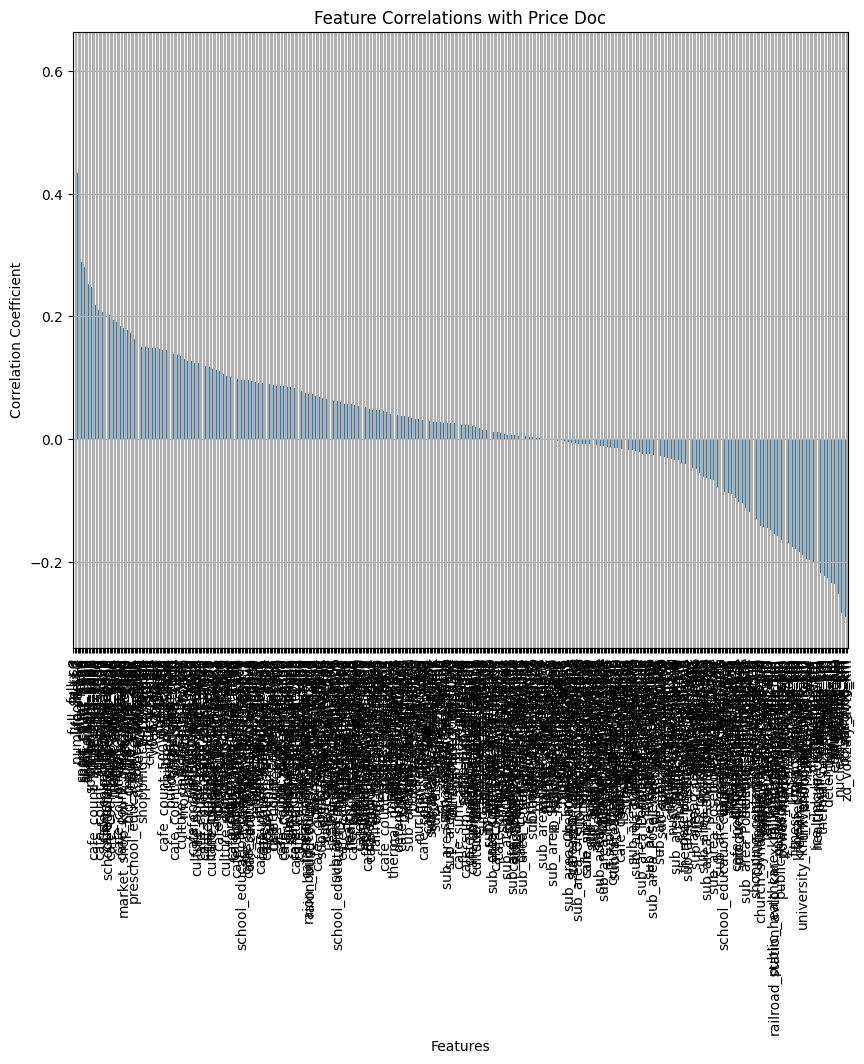

In [209]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Isolate the correlation coefficients for 'price_doc' and sort them
price_doc_corr = corr_matrix['price_doc'].sort_values(ascending=False)

# Remove 'price_doc' correlation with itself for clarity in the plot
price_doc_corr = price_doc_corr[price_doc_corr.index != 'price_doc']

# Plotting the correlation with 'price_doc
plt.figure(figsize=(10, 8))
price_doc_corr.plot(kind='bar')
plt.title('Feature Correlations with Price Doc')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

# Filter the DataFrame to keep only features with a correlation coefficient > 0
important_features = price_doc_corr[price_doc_corr > 0.2].index.tolist()
df = df[important_features + ['price_doc']]

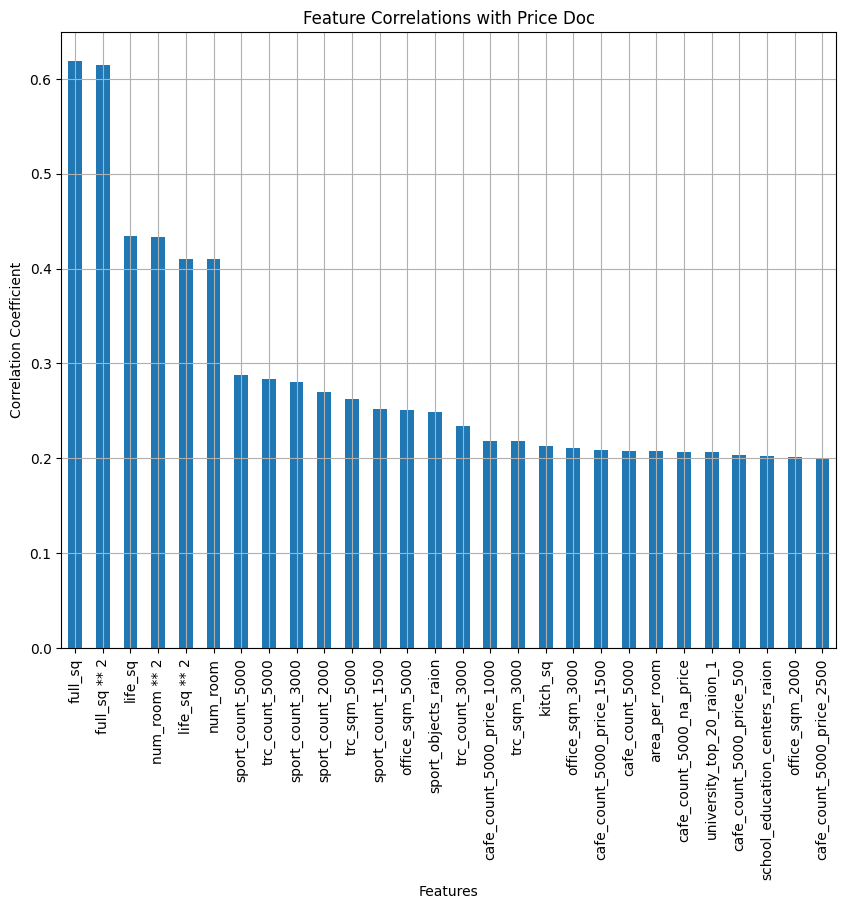

In [210]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Isolate the correlation coefficients for 'price_doc' and sort them
price_doc_corr = corr_matrix['price_doc'].sort_values(ascending=False)

# Remove 'price_doc' correlation with itself for clarity in the plot
price_doc_corr = price_doc_corr[price_doc_corr.index != 'price_doc']

# Plotting the correlation with 'price_doc
plt.figure(figsize=(10, 8))
price_doc_corr.plot(kind='bar')
plt.title('Feature Correlations with Price Doc')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

In [211]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [212]:
# Filter the list to include only existing columns in test_df
existing_important_features = [feature for feature in important_features if feature in test_df.columns]

# Subset the DataFrame to only include the existing important features
test_df = test_df[existing_important_features]

In [213]:
# Remove extra columns from df
for column in df.columns:
    if column not in test_df.columns and column != 'price_doc':
         df.drop(columns=[column], inplace=True)

# Remove extra columns from test_df
for column in test_df.columns:
    if column not in df.columns:
        test_df.drop(columns=[column], inplace=True)

In [214]:
print("Columns in X_train not in X_test:", set(df.columns) - set(test_df.columns))
print("Columns in X_test not in X_train:", set(test_df.columns) - set(df.columns))

Columns in X_train not in X_test: {'price_doc'}
Columns in X_test not in X_train: set()


In [215]:
print(df.shape)
print(test_df.shape)

(29889, 29)
(7662, 28)


# Model Advancing
1. Random Forest model
2. XGBoost model
3. LGB model

In [216]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV

# X = df.drop('price_doc', axis=1)
# y = df['price_doc']
# # y = np.log1p(df['price_doc'])

# # Splitting data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

# # Create the random forest model
# model = RandomForestRegressor()

# # Perform randomized search
# random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=2, cv=5, random_state=42)

# # Fit the model to the training data
# random_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

# # Make predictions on the test data using the best model
# y_pred_rf = best_model.predict(X_test)

# # Calculate the mean squared error
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# print("Mean Squared Error:", mse_rf, 'Length mse:', len(str(round(mse_rf))))
# print("Best Parameters:", best_params)


In [217]:
# #RandomForestClassifier is supposed to be better then regular RandomForestRegressor

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV

# X = df.drop('price_doc', axis=1)
# y = df['price_doc']
# # y = np.log1p(df['price_doc'])

# # Splitting data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

# # Create the random forest model
# model = RandomForestClassifier()

# # Perform randomized search
# random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=2, cv=5, random_state=42)

# # Fit the model to the training data
# random_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

# # Make predictions on the test data using the best model
# y_pred_rf = best_model.predict(X_test)

# # Calculate the accuracy score
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print("Accuracy Score:", accuracy_rf, 'Length accuracy:', len(str(round(accuracy_rf, 4))))
# print("Best Parameters:", best_params)

In [218]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error

# # Data splitting
# X = df.drop('price_doc', axis=1)
# y = df['price_doc']
# # y = np.log1p(df['price_doc'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Model initialization
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# # Parameter grid
# params = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'colsample_bytree': [0.3, 0.7]
# }

# # Hyperparameter tuning
# grid = GridSearchCV(xg_reg, params, verbose=1, cv=3, n_jobs=-1)
# grid.fit(X_train, y_train)

# # Best parameters and model
# print("Best parameters found: ", grid.best_params_)
# best_xgb_model = grid.best_estimator_

# # Evaluation
# y_pred_xgb = best_xgb_model.predict(X_test)
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# print("Mean Squared Error: ", mse_xgb, 'Length mse:', len(str(round(mse_xgb))))

In [219]:
# # Export predictions as CSV

# from google.colab import files

# df.to_csv('New_Train.csv', index=False)

# files.download('New_Train.csv')

In [220]:
# # Export predictions as CSV

# from google.colab import files

# test_df.to_csv('New_Test.csv', index=False)

# files.download('New_Test.csv')

In [221]:
'''X_train = df.drop('price_doc', axis=1)
y_train = np.log1p(df['price_doc'])
X_test = test_df

X_test = X_test[X_train.columns]  # Ensuring order strictly matches

# Setup the model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Hyperparameter tuning setup
params = {
    "colsample_bytree": [0.3, 0.7],
    "gamma": [0, 0.1, 0.2],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [4, 6, 8],
    "n_estimators": [100, 200, 300, 400, 500],
    "subsample": [0.6, 0.8, 1.0]
}

# Randomized search on hyper parameters
random_search = RandomizedSearchCV(xg_reg, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=3, random_state=42)

# Training the model
random_search.fit(X_train, y_train)

# Best estimator
best_xgb = random_search.best_estimator_

# Predicting and Evaluating
y_pred_test = best_xgb.predict(X_test)
y_pred_test = np.expm1(y_pred_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"MSE: {mse:.2f}")
# print("Best Parameters:", random_search.best_params_)'''

'X_train = df.drop(\'price_doc\', axis=1)\ny_train = np.log1p(df[\'price_doc\'])\nX_test = test_df\n\nX_test = X_test[X_train.columns]  # Ensuring order strictly matches\n\n# Setup the model\nxg_reg = xgb.XGBRegressor(objective =\'reg:squarederror\', seed=42)\n\n# Hyperparameter tuning setup\nparams = {\n    "colsample_bytree": [0.3, 0.7],\n    "gamma": [0, 0.1, 0.2],\n    "learning_rate": [0.01, 0.1, 0.2],\n    "max_depth": [4, 6, 8],\n    "n_estimators": [100, 200, 300, 400, 500],\n    "subsample": [0.6, 0.8, 1.0]\n}\n\n# Randomized search on hyper parameters\nrandom_search = RandomizedSearchCV(xg_reg, param_distributions=params, n_iter=5, scoring=\'neg_mean_squared_error\', n_jobs=-1, cv=5, verbose=3, random_state=42)\n\n# Training the model\nrandom_search.fit(X_train, y_train)\n\n# Best estimator\nbest_xgb = random_search.best_estimator_\n\n# Predicting and Evaluating\ny_pred_test = best_xgb.predict(X_test)\ny_pred_test = np.expm1(y_pred_test)\n# mse = mean_squared_error(y_test, y_

Random forest MSE = 6274411116013.969
RandomForestClassifier MSE =

XGBoost MSE = 4947192476493.555
LightGBM MSE = 4877120243679.092 Best !!

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Assuming 'df' and 'test_df' are already defined and preprocessed appropriately
X_train = df.drop('price_doc', axis=1)
y_train = np.log1p(df['price_doc'])  # Transforming the target variable for normalization
X_test = test_df

# Model initialization with LightGBM
lgb_reg = lgb.LGBMRegressor(objective='regression', random_state=42)

# Parameter grid definition for hyperparameter tuning
params = {
    "colsample_bytree": [0.25, 0.3, 0.35],
    "learning_rate": [0.03, 0.05, 0.07],
    "max_depth": [4, 5, 6],
    "n_estimators": [325, 350, 375],
    "subsample": [0.1, 0.2, 0.3]
}

# Setting up GridSearchCV for hyperparameter tuning
grid = GridSearchCV(lgb_reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=3)

# Fitting the model to the training data
grid.fit(X_train, y_train)

# Outputting the best parameters and the best model from GridSearch
print("Best parameters found: ", grid.best_params_)
best_lgb_model = grid.best_estimator_

# Making predictions on the test set using the best model
y_pred_lgb = best_lgb_model.predict(X_test)
# Transform predictions back to the original price scale
y_pred_test = np.expm1(y_pred_lgb)

# Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.6}
# Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.4}
# Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 350, 'subsample': 0.2}

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [223]:
'''import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Prepare the data
X = df.drop('price_doc', axis=1)
y = np.log1p(df['price_doc'])  # Log transformation of the target
X_test = test_df  # Test data without the target variable

# Initialize base models
estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=100, random_state=42)),
    ('XGBRegressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)),
    ('LGBMRegressor', lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42))
]

# Initialize Stacking Regressor with a linear regression model as a final estimator
stack_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=5)

# Fit the stacking model
stack_reg.fit(X, y)

# Predict on the test dataset
y_pred_test = stack_reg.predict(X_test)
y_pred_test = np.expm1(y_pred_test)  # Convert log predictions back to normal scale'''

"import numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import KFold, train_test_split\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor\nfrom sklearn.linear_model import LinearRegression\nimport xgboost as xgb\nimport lightgbm as lgb\nfrom sklearn.metrics import mean_squared_error\n\n# Prepare the data\nX = df.drop('price_doc', axis=1)\ny = np.log1p(df['price_doc'])  # Log transformation of the target\nX_test = test_df  # Test data without the target variable\n\n# Initialize base models\nestimators = [\n    ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),\n    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),\n    ('ExtraTrees', ExtraTreesRegressor(n_estimators=100, random_state=42)),\n    ('XGBRegressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)),\n    ('LGBMRegressor', lgb.LGBMRegressor(objective='re

In [224]:
# Export predictions as CSV

from google.colab import files

y_pred_df = pd.DataFrame(y_pred_test, columns=['price_doc'], index=(X_test.index + 30474).rename('id'))
y_pred_df.to_csv('predicted_price_doc_LGB4.csv', index=True)

files.download('predicted_price_doc_LGB4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [225]:
y_pred_df.shape

(7662, 1)